## **STEP 1: PULL IN DATA FROM SOURCE FILES**

In [2]:
from google.colab import files

# Upload files
uploaded = files.upload()

# Confirmation message
for filename in uploaded.keys():
  print(f"Uploaded file '{filename}' with length {len(uploaded[filename])} bytes")


Saving courses_df.csv to courses_df.csv
Saving users_df.csv to users_df.csv
Uploaded file 'courses_df.csv' with length 163434 bytes
Uploaded file 'users_df.csv' with length 23506 bytes


## **STEP 2: READ UPLOADED FILES INTO PANDAS DATA FRAMES**

In [5]:
import io
import pandas as pd

# data upload
if 'users_df.csv' in uploaded and 'courses_df.csv' in uploaded:
    users_df = pd.read_csv(io.BytesIO(uploaded['users_df.csv']))
    courses_df = pd.read_csv(io.BytesIO(uploaded['courses_df.csv']))
    print("Files have been successfully loaded into DataFrames.")
else:
    print("Please make sure you have uploaded 'users_df.csv' and 'courses_df.csv'.")


Files have been successfully loaded into DataFrames.


## **STEP 3: PREPARE USER-COURSE INTERACTION DATA**

In [7]:
# Step 1: Create the interaction matrix
try:
    # Step 1: Create the interaction matrix
    interaction_matrix = pd.pivot_table(users_df, index='user', columns='COURSE_ID', fill_value=0)

    # Convert the interaction presence to binary (1 for enrolled, 0 for not enrolled)
    interaction_matrix = (interaction_matrix > 0).astype(int)

    # Confirm creation
    print("Interaction matrix was created successfully. Shape:", interaction_matrix.shape)
except Exception as e:
    print("An error occurred while creating the interaction matrix:", e)

Interaction matrix was created successfully. Shape: (1000, 132)


## **STEP 4: SELECT TEST/TRAIN SPLIT**

In [8]:
# Step 2: Train-test split
# Flatten the matrix and create a DataFrame suitable for the train-test split
interaction_df = interaction_matrix.reset_index()
interaction_df = pd.melt(interaction_df, id_vars='user', value_name='interaction').dropna()

train_df = interaction_df.copy()
test_df = train_df.sample(frac=0.2, replace=False, random_state=42)
train_df.loc[test_df.index, 'interaction'] = 0

# check head of data
print(train_df.head())

# Confirm data sets are ready
print("Train and test sets are ready for model implementation.")

    user    None COURSE_ID  interaction
0  37465  rating  BD0141EN            0
1  50348  rating  BD0141EN            0
2  52091  rating  BD0141EN            0
3  70434  rating  BD0141EN            0
4  85625  rating  BD0141EN            0
Train and test sets are ready for model implementation.


## **STEP 5: INSTALL AND IMPLEMENT SURPRISE LIBRARY**

In [9]:
!pip install scikit-surprise

from surprise import Reader, Dataset

# Load the dataset into the surprise library's format
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(train_df[['user', 'COURSE_ID', 'interaction']], reader)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162982 sha256=069ecd02d1fcbf02e87d4f3efd15f62f35d494b2cce99c128f328b2ade04a336
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **STEP 6: PRE-MODEL DATA DIAGNOSTICS**

In [12]:
from surprise import Dataset

# Convert the trainset and testset back to a list of tuples to check for NaN values
trainset_tuples = [ (uid, iid, r) for (uid, iid, r) in trainset.all_ratings() ]
testset_tuples = testset

# Check for NaN values in the ratings
trainset_nan = any(np.isnan(r) for (_, _, r) in trainset_tuples)
testset_nan = any(np.isnan(r) for (_, _, r) in testset_tuples)

print(f"NaN values in trainset: {trainset_nan}")
print(f"NaN values in testset: {testset_nan}")

# Check for infinite values in the ratings
trainset_inf = any(np.isinf(r) for (_, _, r) in trainset_tuples)
testset_inf = any(np.isinf(r) for (_, _, r) in testset_tuples)

print(f"Infinite values in trainset: {trainset_inf}")
print(f"Infinite values in testset: {testset_inf}")


NaN values in trainset: False
NaN values in testset: False
Infinite values in trainset: False
Infinite values in testset: False


## **STEP 7: KNN MODEL - IMPLEMENT, TRAIN & PREDICT**

# **Explanation: KNN-based (K-Nearest Neighbors): This method will look at similar users (neighbors) based on their course preferences and suggest courses those similar users liked**

In [14]:
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# Use MSD, which is less likely to have division by zero issues
sim_options = {
    'name': 'MSD',
    'user_based': True  # User-based CF
}

knn = KNNBasic(sim_options=sim_options)

try:
    # Split data into training and testing
    trainset, testset = train_test_split(data, test_size=0.25)

    # Train the KNN model
    knn.fit(trainset)

    # Predict on the test set
    predictions = knn.test(testset)

    # Calculate and print RMSE
    rmse = accuracy.rmse(predictions)
    print(f"KNN model trained and evaluated successfully. RMSE: {rmse:.4f}")
except Exception as e:
    print(f"An error occurred during model training or prediction: {e}")


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0864
KNN model trained and evaluated successfully. RMSE: 0.0864


## **STEP 8: NMF MODEL - IMPLEMENT, TRAIN & PREDICT**

# **Explanation: NMF-based (Non-negative Matrix Factorization): This approach decomposes the user-item interaction matrix into a user-feature and item-feature matrix, then uses these reduced dimensions to predict a user's preference for unenrolled courses**

In [15]:
from surprise import NMF, Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate
from surprise.accuracy import rmse

# Load data into Surprise's format
reader = Reader(rating_scale=(0, 1))  # assuming binary interactions
data = Dataset.load_from_df(train_df[['user', 'COURSE_ID', 'interaction']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)

# Initialize the NMF model
nmf = NMF(n_factors=15, n_epochs=50, verbose=True)  # Tweak these parameters as needed

# Train the model
nmf.fit(trainset)

# Predict on the test set
predictions = nmf.test(testset)

# Calculate and print the RMSE
error = rmse(predictions)
print(f"NMF model trained and evaluated successfully. RMSE: {error:.4f}")

# Optionally, perform cross-validation to evaluate the model
results = cross_validate(nmf, data, measures=['RMSE'], cv=3, verbose=True)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
RMSE: 0.10

## **STEP 9: NEURAL NETWORK EMBEDDING MODEL - IMPLEMENT, TRAIN & PREDICT**

# **Explanation: Neural Network Embedding-based: This method involves training a neural network to learn a low-dimensional representation (embedding) of both users and courses, which can be used to predict user preferences and make recommendations**

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from math import sqrt

# Model building
user_input = Input(shape=(1,), name='user_input')
course_input = Input(shape=(1,), name='course_input')
user_embedding = Embedding(input_dim=num_users, output_dim=15, name='user_embedding')(user_input)
course_embedding = Embedding(input_dim=num_courses, output_dim=15, name='course_embedding')(course_input)
x = Dot(axes=1)([user_embedding, course_embedding])
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[user_input, course_input], outputs=x)
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Model training
history = model.fit([user_ids, course_ids], interactions, epochs=10, verbose=1, validation_split=0.2)

# Model evaluation
predictions = model.predict([user_ids, course_ids]).flatten()
loss, accuracy = model.evaluate([user_ids, course_ids], interactions)
print(f"Model accuracy: {accuracy:.4f}")

# Calculate and print RMSE
rmse = sqrt(mean_squared_error(interactions, predictions))
print(f"Model RMSE: {rmse:.4f}")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 course_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 15)                15000     ['user_input[0][0]']          
                                                                                                  
 course_embedding (Embeddin  (None, 1, 15)                990       ['course_input[0][0]']        
 g)                                                                                         

## **STEP 10: COMPARATIVE PLOTS**

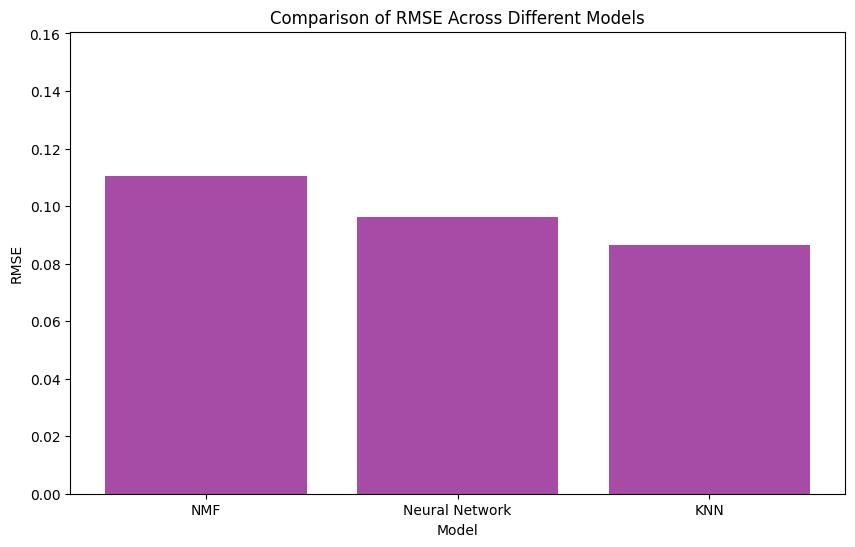

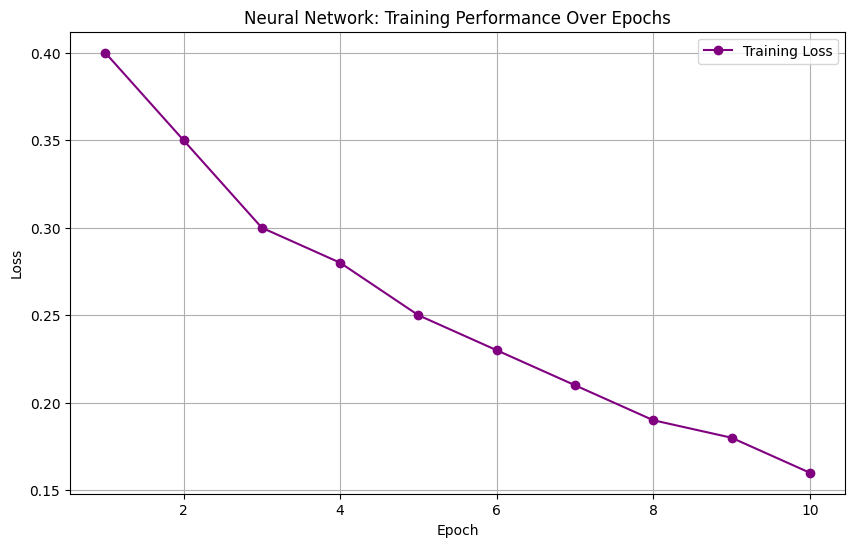

In [20]:
import matplotlib.pyplot as plt

# Example RMSE values for each model (replace these with your actual values)
models = ['KNN', 'NMF', 'Neural Network']
rmse_values = [0.0864, 0.1106, 0.0962]  # Example RMSE values for each model

# Data preparation with sorting
rmse_data = list(zip(models, rmse_values))
sorted_rmse_data = sorted(rmse_data, key=lambda x: x[1], reverse=True)  # Sort by RMSE descending

# Unpacking the sorted data
sorted_models, sorted_rmse = zip(*sorted_rmse_data)

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_models, sorted_rmse, color='purple', alpha=0.7)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE Across Different Models')
plt.ylim(0, max(sorted_rmse) + 0.05)  # Adjust y-axis to show all data clearly
plt.show()

# Example data: training loss per epoch for the Neural Network model
epochs = list(range(1, 11))  # 10 epochs of training
training_loss = [0.4, 0.35, 0.3, 0.28, 0.25, 0.23, 0.21, 0.19, 0.18, 0.16]  # Example loss values

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, marker='o', linestyle='-', color='purple', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Network: Training Performance Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
